# Segmenting and Clustering Neighborhoods in Vancouver City

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from urllib.request import urlopen
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# website scraping libraries and packages in Python from BeautifulSoup 
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup as bsoup

# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Libraries imported.


In [2]:
# Vancouver neighborhoods
van_neighborhoods = ['Arbutus Ridge', 'Cedar Cottage', 'Champlain Heights', 'Chinatown', 'Coal Harbour', 'Collingwood',
                     'Commercial Drive', 'Creekside', 'Downtown', 'Downtown Eastside', 'Dunbar-Southlands', 'Fairview',
                     'False Creek North', 'False Creek South', 'Gastown', 'Grandview-Woodland', 'Granville Island',
                     'Hastings-Sunrise', 'Hastings Crossing', 'Hastings East', 'Kensington-Cedar Cottage', 'Kerrisdale',
                     'Killarney', 'Kitsilano', 'Knight', 'Langara', 'Little Mountain', 'Main', 'Marpole', 'Mole Hill',
                     'Mount Pleasant', 'Musqueam', 'Oakridge', 'Quilchena', 'Renfrew-Collingwood', 'Riley Park',
                     'Shaughnessy', 'South Cambie', 'South Granville', 'South Hill', 'South Vancouver', 'Southlands',
                     'Southwest Marine', 'Sunrise', 'Sunset', 'Victoria-Fraserview', 'West Broadway', 'West End', 'West Point Grey', 'Yaletown']

In [3]:
df_van = pd.DataFrame(van_neighborhoods)
df_van.columns = ['Neighborhood']
df_van.head()

,Neighborhood
0,Arbutus Ridge
1,Cedar Cottage
2,Champlain Heights
3,Chinatown
4,Coal Harbour


In [4]:
#create a function to handle TimeOuts from Geocoder
from geopy.exc import GeocoderTimedOut
locator = Nominatim(user_agent = "bostonagent")

def do_geocode(address):
    try:
        return locator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [5]:
neighborhoods = df_van.values.tolist()

latitude = []
longitude = []
for neighborhood in neighborhoods:
    coord = do_geocode('{}, Vancouver'.format(neighborhood))
    
    #check to make sure all latitude and longitude values are present in the Nominatim API
    #handles the case where Nominatim returns a 'None' object because the neighborhood does not exist in their API
    
    if (coord == None):
        latitude.append('0')
        longitude.append('0')
    else:
        latitude.append(coord.latitude)
        longitude.append(coord.longitude)

#add coordinates columns to dataframe
df_van['Latitude'] = latitude
df_van['Longitude'] = longitude
print(f'\nNumber of Neighborhoods: {df_van.shape[0]}\n')
df_van.head()


Number of Neighborhoods: 50



,Neighborhood,Latitude,Longitude
0,Arbutus Ridge,49.240968,-123.167001
1,Cedar Cottage,49.251622,-123.064548
2,Champlain Heights,49.215266,-123.030915
3,Chinatown,49.279981,-123.104089
4,Coal Harbour,49.290375,-123.129281


In [6]:
address = 'Vancouver City'

#Get lat/long values for Boston and print them
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Vancouver are {latitude:.4f}, {longitude:.4f}.')

The geograpical coordinates of Vancouver are 49.2609, -123.1140.


In [7]:
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map for each neighborhood
for lat, lng, neighborhood in zip(df_van['Latitude'], df_van['Longitude'], df_van['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#29BBB9',
        fill_opacity=0.7,
        parse_html=False).add_to(vancouver_map)  
    
vancouver_map

In [8]:
CLIENT_ID = 'xxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
# Explore Neighborhoods in Vancouver

LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Create a new dataframe called brooklyn_venues
van_venues = getNearbyVenues(names=df_van['Neighborhood'],
                                   latitudes=df_van['Latitude'],
                                   longitudes=df_van['Longitude'])
print('\nDone!')

..................................................
Done!


In [10]:
#DataFrame of the most frequent venues in Vancouver

#group by category
mostpop= van_venues.groupby('Venue Category').count()

#sort values in descending order
mostpop = mostpop.sort_values(by = 'Neighborhood', ascending = False)

#select only the top 10 venues
mostpop= mostpop[0:10]

#reset index for visualization
mostpop.reset_index(inplace=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


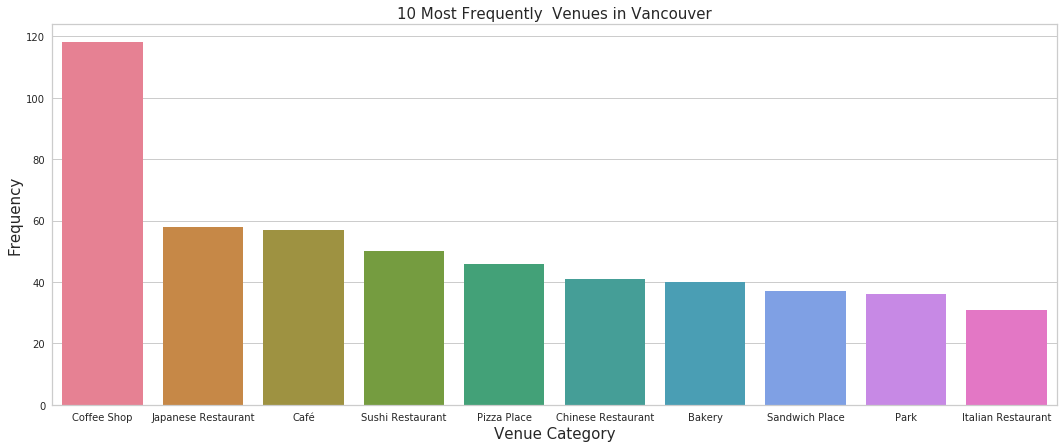

In [11]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Neighborhood",  palette="husl",saturation = 0.75, data=mostpop)
sns.set_context("paper")
s.set_xticklabels(s.get_xticklabels())
plt.title('10 Most Frequently  Venues in Vancouver', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()
fig.savefig('10most-fre-ven-Vancouver.png', dpi=300)

In [12]:
# Checking the size of the resulting dataframe
print(van_venues.shape)
van_venues.head(10)

(1730, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.240968,-123.167001,Butter Baked Goods,49.242209,-123.170381,Bakery
1,Arbutus Ridge,49.240968,-123.167001,The Haven,49.241377,-123.166331,Spa
2,Arbutus Ridge,49.240968,-123.167001,Barktholomews Pet Supplies,49.242746,-123.170193,Pet Store
3,Arbutus Ridge,49.240968,-123.167001,The Dragon's Layer,49.238518,-123.169029,Nightlife Spot
4,Arbutus Ridge,49.240968,-123.167001,The Heights Market,49.237902,-123.170949,Grocery Store
5,Cedar Cottage,49.251622,-123.064548,Commercial Street Cafe,49.252539,-123.068178,Café
6,Cedar Cottage,49.251622,-123.064548,Trout Lake Community Centre,49.255403,-123.065048,Gym
7,Cedar Cottage,49.251622,-123.064548,Trout Lake Fitness Centre,49.255601,-123.065317,Gym / Fitness Center
8,Cedar Cottage,49.251622,-123.064548,The Lower Mainland Childbearing Society,49.252836,-123.068136,Child Care Service
9,Cedar Cottage,49.251622,-123.064548,Flourist Mill & Bakery,49.253881,-123.068209,Bakery


In [13]:
# Checking how many veneus were returned for each neighborhood
van_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbutus Ridge,5,5,5,5,5,5
Cedar Cottage,9,9,9,9,9,9
Champlain Heights,5,5,5,5,5,5
Chinatown,100,100,100,100,100,100
Coal Harbour,98,98,98,98,98,98


In [14]:
# Analyze Each Neighborhood

# one hot encoding
van_onehot = pd.get_dummies(van_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
van_onehot['Neighborhood'] = van_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [van_onehot.columns[-1]] + list(van_onehot.columns[:-1])
van_onehot = van_onehot[fixed_columns]

print(van_onehot.shape)
van_onehot.head()

(1730, 229)


,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Heliport,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Inn,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trade School,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arbutus Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [15]:
# Removing records where venue is "building" or "office"
van_venues = van_venues[~van_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(van_venues.shape)
van_venues.head()

(1706, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.240968,-123.167001,Butter Baked Goods,49.242209,-123.170381,Bakery
1,Arbutus Ridge,49.240968,-123.167001,The Haven,49.241377,-123.166331,Spa
2,Arbutus Ridge,49.240968,-123.167001,Barktholomews Pet Supplies,49.242746,-123.170193,Pet Store
3,Arbutus Ridge,49.240968,-123.167001,The Dragon's Layer,49.238518,-123.169029,Nightlife Spot
4,Arbutus Ridge,49.240968,-123.167001,The Heights Market,49.237902,-123.170949,Grocery Store


In [16]:
# let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
van_grouped = van_onehot.groupby('Neighborhood').mean().reset_index()
print(van_grouped.shape)
van_grouped.head()

(50, 229)


,Neighborhood,Accessories Store,Airport Terminal,American Restaurant,Amphitheater,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Heliport,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Inn,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trade School,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0.0,0.000000,0.00,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.200000,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00,0.000000,0.00,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.

In [17]:
def plotTop5(neighborhood, xcoord, ycoord,hood):
    fig = plt.figure(figsize=(5,3))
    sns.despine(left=True)
    s=sns.barplot(x=xcoord, y=ycoord, data=neighborhood, orient = 'v')
    s.set_xticklabels(s.get_xticklabels(),rotation=40, fontsize = 10)
    plt.title('Top 5 Most in {}, Vancouver'.format(hood), fontsize=12)
    plt.xlabel("Venue Category", fontsize=12)
    plt.ylabel ("Frequency", fontsize=12)
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


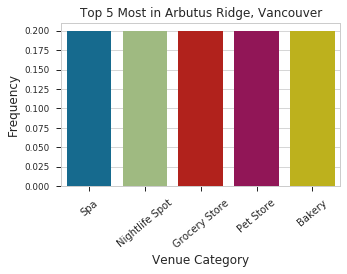

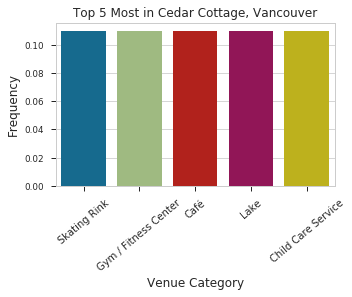

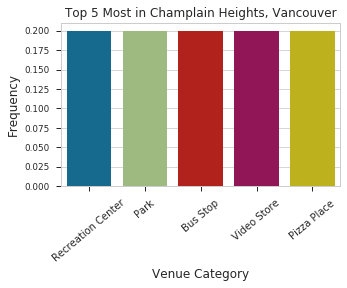

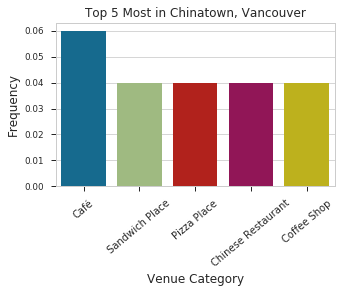

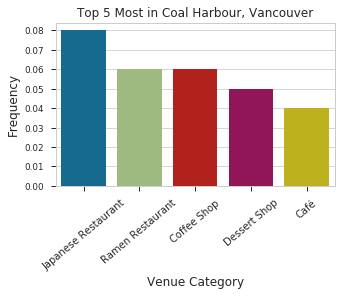

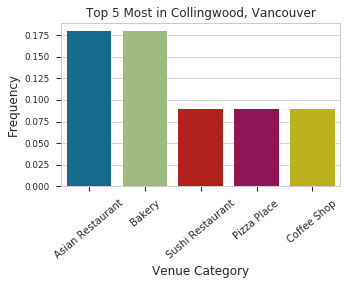

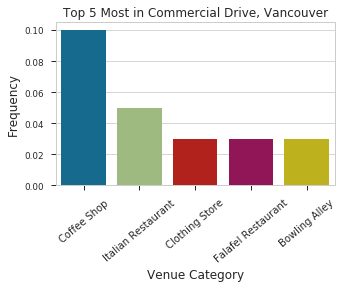

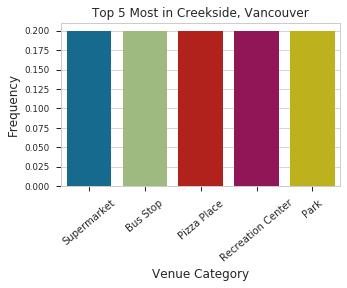

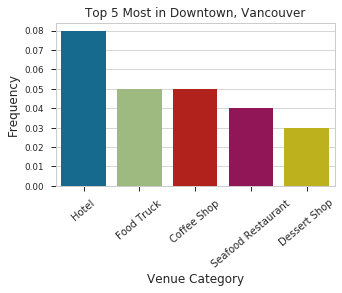

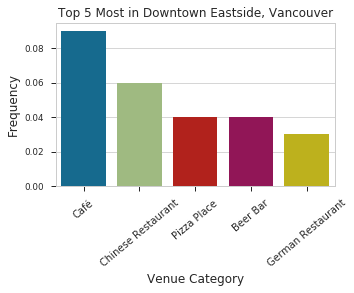

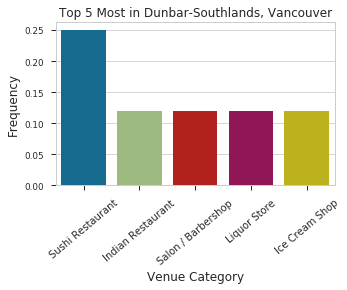

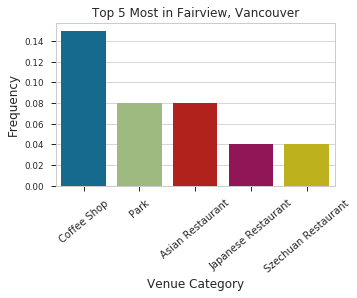

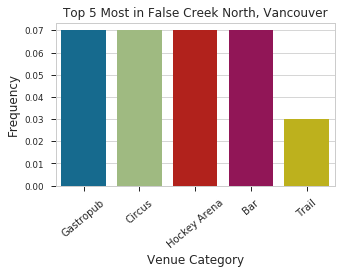

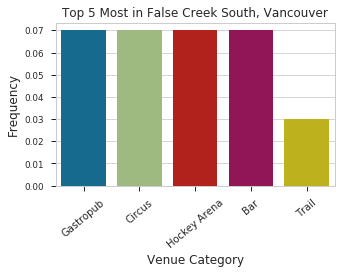

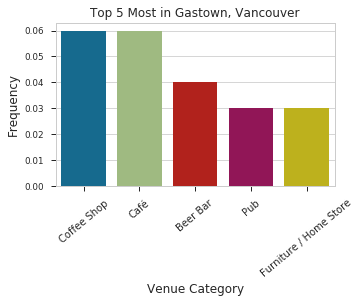

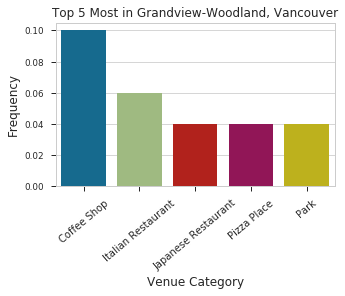

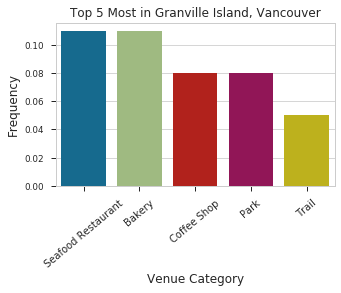

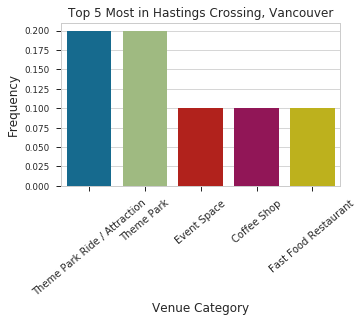

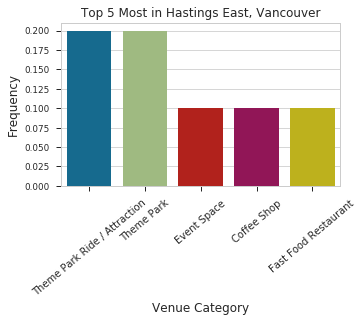

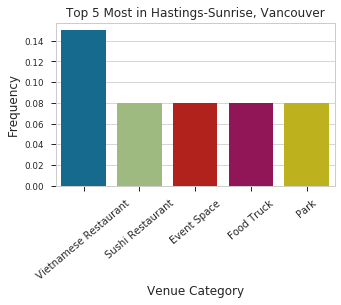

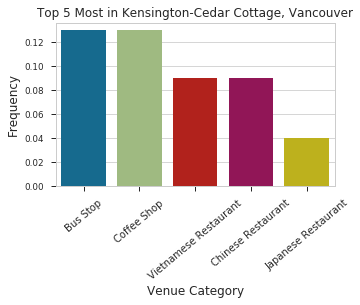

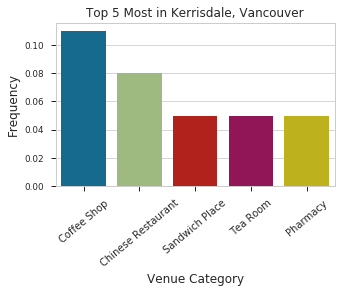

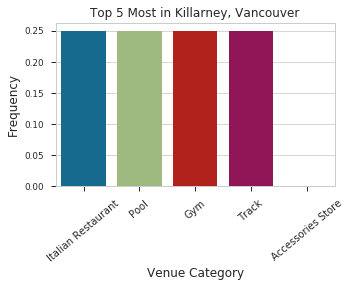

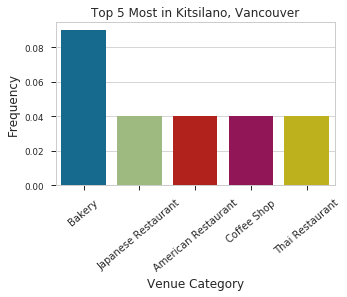

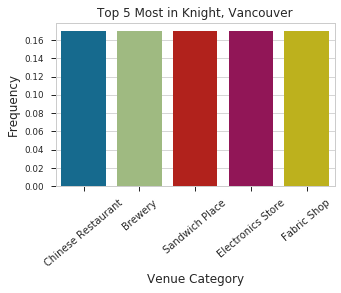

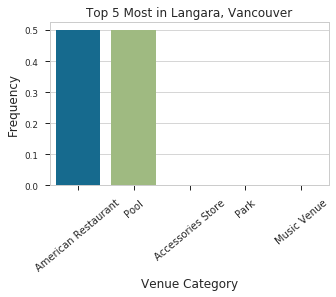

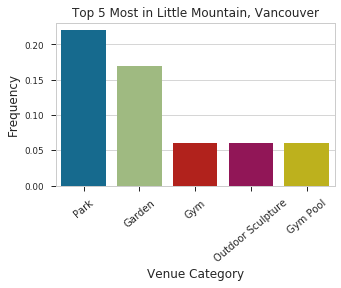

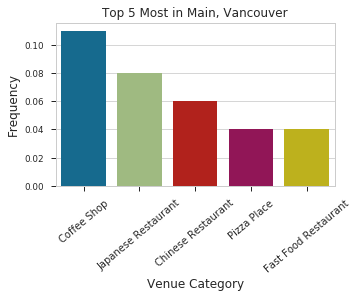

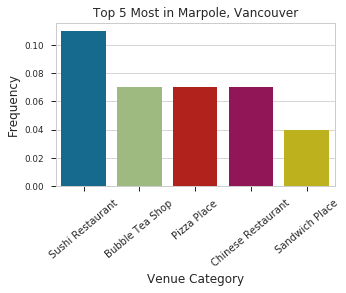

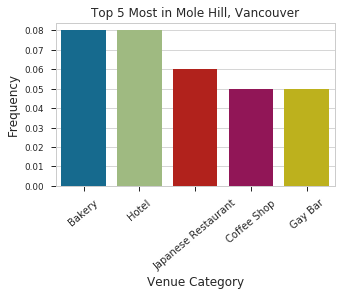

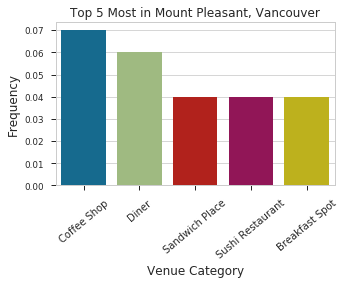

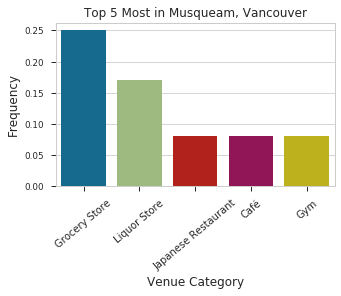

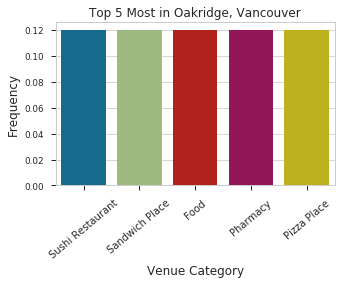

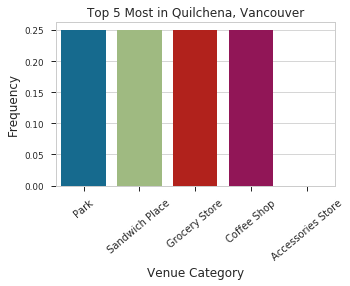

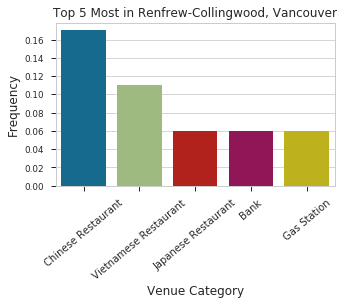

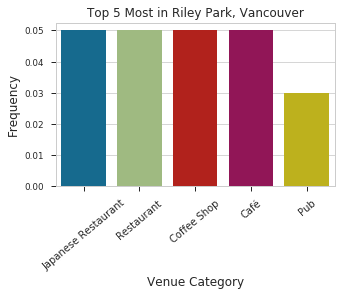

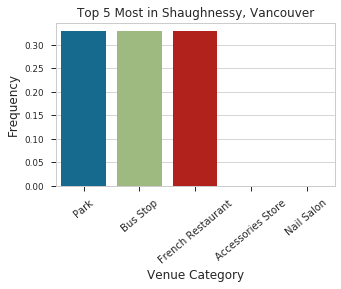

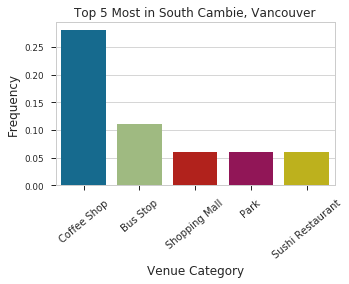

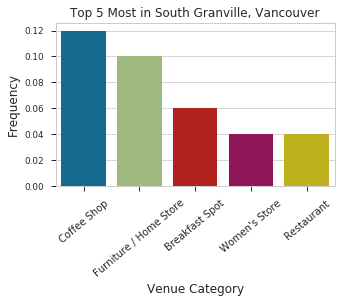

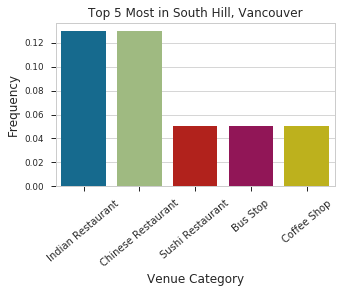

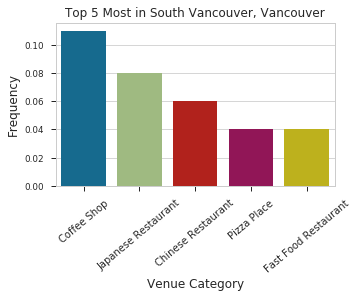

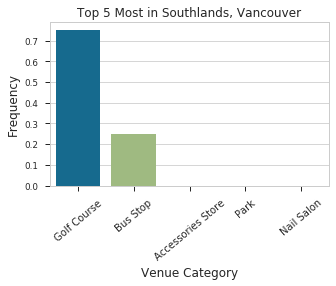

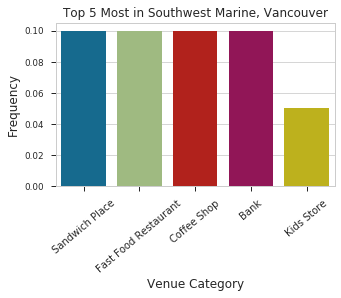

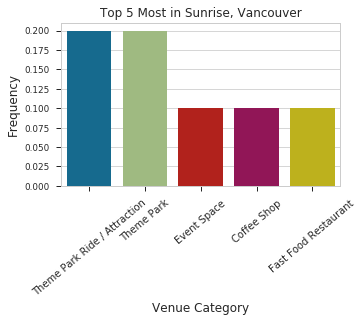

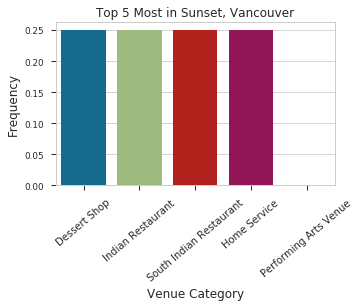

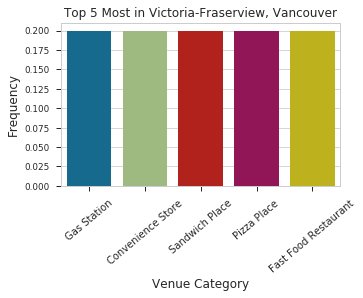

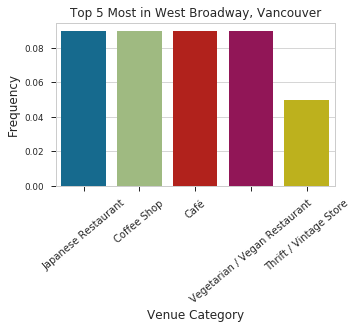

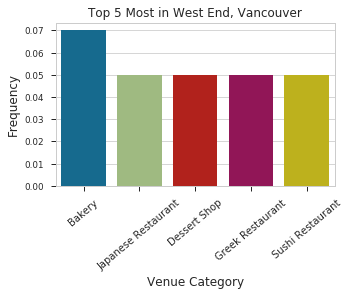

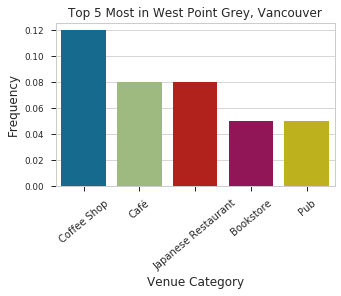

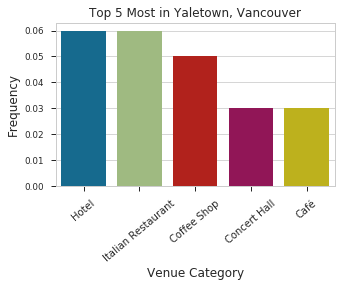

In [18]:
num_top_venues = 5
subplots = 22
for hood in van_grouped['Neighborhood']:
    temp = van_grouped[van_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    temp = temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp = temp[0:5]
    plotTop5(temp, 'Venue' , 'Frequency', hood)

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = van_grouped['Neighborhood']

for ind in np.arange(van_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Spa,Pet Store,Nightlife Spot,Bakery,Grocery Store,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop
1,Cedar Cottage,Lake,Skating Rink,Child Care Service,Bakery,Park,Bookstore,Gym,Gym / Fitness Center,Café,Fish Market
2,Champlain Heights,Video Store,Recreation Center,Park,Pizza Place,Bus Stop,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market
3,Chinatown,Café,Coffee Shop,Sandwich Place,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bakery,Sushi Restaurant,Gastropub,German Restaurant
4,Coal Harbour,Japanese Restaurant,Coffee Shop,Ramen Restaurant,Dessert Shop,Café,Park,Restaurant,Breakfast Spot,Sushi Restaurant,Italian Restaurant


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


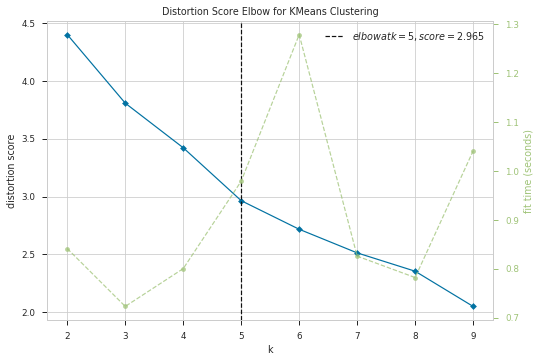

In [21]:
#elbow method to determine best cluster numbers
model = KMeans()
van_grouped_clustering = van_grouped.drop('Neighborhood', 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(van_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()

In [22]:
# The visualization generated by Yellowbrick indicated that a k value of 5 would produce the most effective clusters for our data
# We will be running our K-means clustering algorithm on our weighted van_grouped DataFrame with this k value after removing the Neighborhood name from the DataFrame
# After we generate our cluster labels, we will add them to our Top 10 Venues DataFrame. Again, this will make it easier for us to understand how k-means clustered our neighborhoods in the future

kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(van_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [23]:
# add clustering labels

#uncomment this line if running block again
#neighborhoods_venues_sorted.drop(columns =['Cluster Labels'], axis = 1, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

van_merged = df_van

# merge van_grouped with df to add latitude/longitude for each neighborhood
van_merged = van_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

van_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,49.240968,-123.167001,1,Spa,Pet Store,Nightlife Spot,Bakery,Grocery Store,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop
1,Cedar Cottage,49.251622,-123.064548,1,Lake,Skating Rink,Child Care Service,Bakery,Park,Bookstore,Gym,Gym / Fitness Center,Café,Fish Market
2,Champlain Heights,49.215266,-123.030915,1,Video Store,Recreation Center,Park,Pizza Place,Bus Stop,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market
3,Chinatown,49.279981,-123.104089,1,Café,Coffee Shop,Sandwich Place,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bakery,Sushi Restaurant,Gastropub,German Restaurant
4,Coal Harbour,49.290375,-123.129281,1,Japanese Restaurant,Coffee Shop,Ramen Restaurant,Dessert Shop,Café,Park,Restaurant,Breakfast Spot,Sushi Restaurant,Italian Restaurant


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(van_merged['Latitude'], 
                                  van_merged['Longitude'], 
                                  van_merged['Neighborhood'], 
                                  van_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
# Cluster 1
van_c1 = van_merged.loc[van_merged['Cluster Labels'] == 0,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c1.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Sunset,Dessert Shop,South Indian Restaurant,Home Service,Yoga Studio,Falafel Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


In [26]:
# Cluster 2
van_c2 = van_merged.loc[van_merged['Cluster Labels'] == 1,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c2.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Pet Store,Nightlife Spot,Bakery,Grocery Store,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop
1,Cedar Cottage,Skating Rink,Child Care Service,Bakery,Park,Bookstore,Gym,Gym / Fitness Center,Café,Fish Market
2,Champlain Heights,Recreation Center,Park,Pizza Place,Bus Stop,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market
3,Chinatown,Coffee Shop,Sandwich Place,Pizza Place,Chinese Restaurant,Mexican Restaurant,Bakery,Sushi Restaurant,Gastropub,German Restaurant
4,Coal Harbour,Coffee Shop,Ramen Restaurant,Dessert Shop,Café,Park,Restaurant,Breakfast Spot,Sushi Restaurant,Italian Restaurant


In [27]:
# Cluster 3
van_c3 = van_merged.loc[van_merged['Cluster Labels'] == 2,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c3.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Southlands,Bus Stop,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


In [28]:
# Cluster 4
van_c4 = van_merged.loc[van_merged['Cluster Labels'] == 3,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c4.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Hastings Crossing,Theme Park Ride / Attraction,Fast Food Restaurant,Amphitheater,Bus Stop,Event Space,Soccer Field,Coffee Shop,Fish Market,Field
19,Hastings East,Theme Park Ride / Attraction,Fast Food Restaurant,Amphitheater,Bus Stop,Event Space,Soccer Field,Coffee Shop,Fish Market,Field
43,Sunrise,Theme Park Ride / Attraction,Fast Food Restaurant,Amphitheater,Bus Stop,Event Space,Soccer Field,Coffee Shop,Fish Market,Field


In [29]:
# Cluster 5
van_c5 = van_merged.loc[van_merged['Cluster Labels'] == 4,
                           van_merged.columns[[0] + list(range(5, van_merged.shape[1]))]]
van_c5.head()

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Langara,Pool,Yoga Studio,Farmers Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


In [30]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


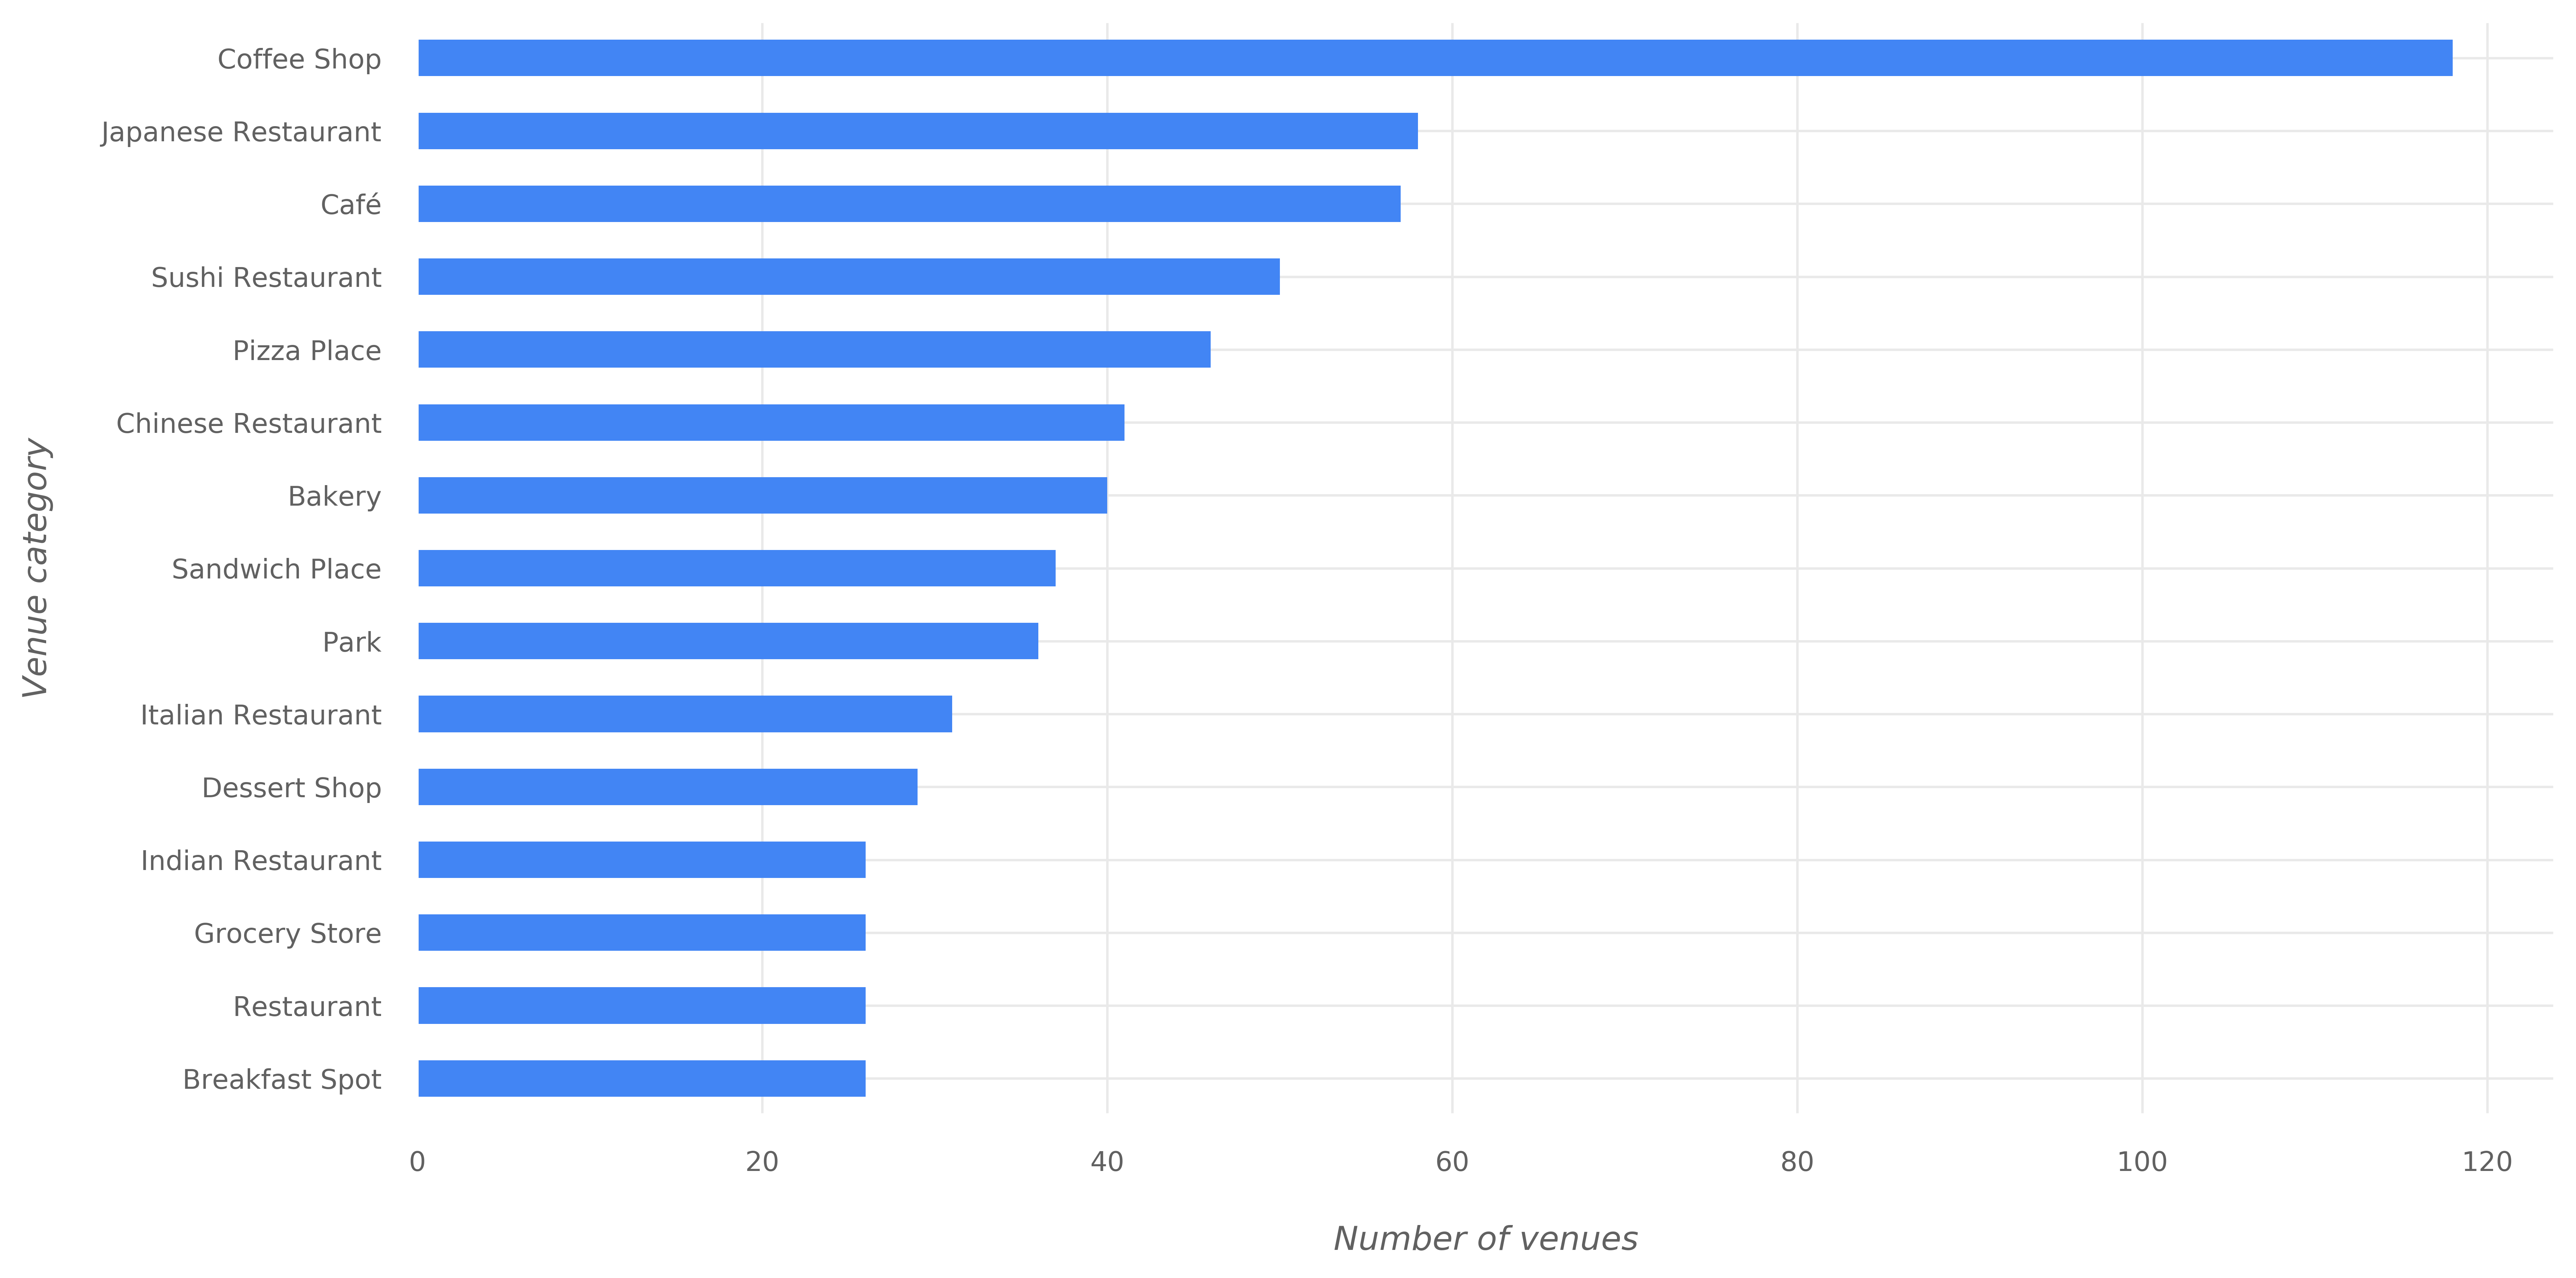

In [31]:
# Most Common Venue Categories in Vancouver

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_top_vc = van_venues['Venue Category'].value_counts(normalize=False)
ax = van_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-Vancouver.png', dpi=300)

50 neighborhoods in Vancouver


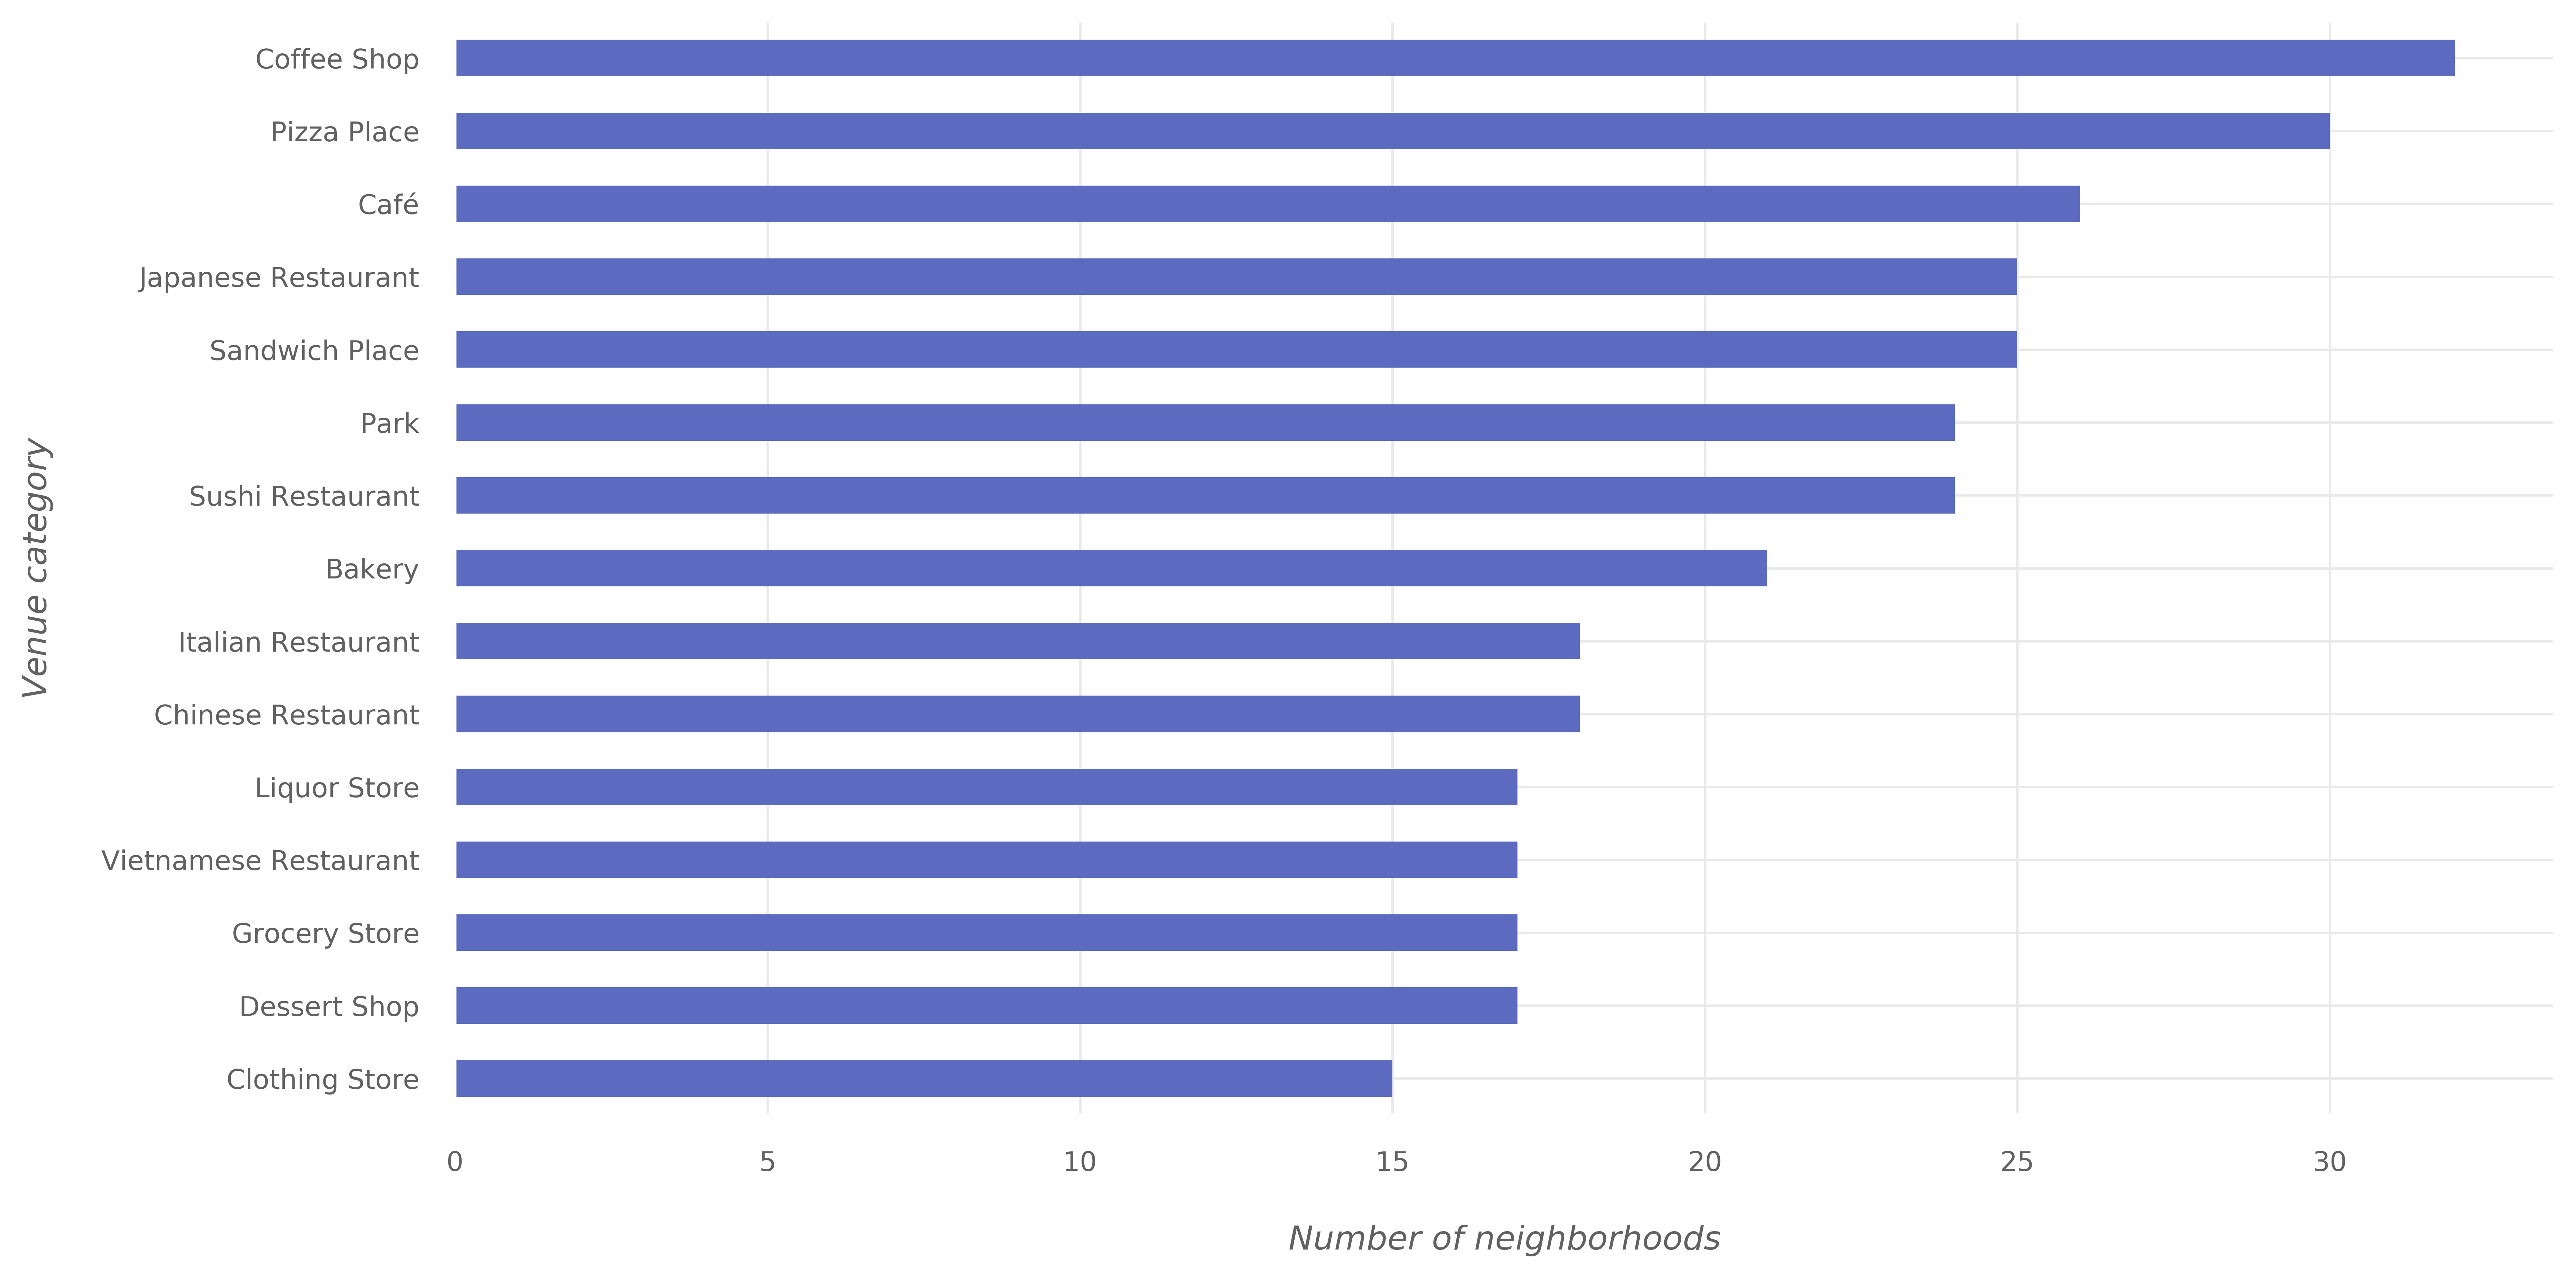

In [32]:
# Which Venue Categories Exist in More Vancouver Neighborhoods?

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
van_g = van_onehot.groupby('Neighborhood').max().reset_index()
van_p = van_g.drop('Neighborhood', axis=1).sum().sort_values(ascending=False)
print(f"{van_g.shape[0]} neighborhoods in Vancouver")
ax = van_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-Vancouver.png', dpi=300)

In [33]:
# Rare Categories in Vancouver

van_bot_vc = van_venues['Venue Category'].value_counts(normalize=False)
van_bot_vc = van_bot_vc.tail(15).to_frame('Count')
van_bot_vc.index.names = ['Venue Category']
van_bot_vc

,Count
Venue Category,
Cheese Shop,1
Water Park,1
Shop & Service,1
Pool Hall,1
Kids Store,1
Portuguese Restaurant,1
Massage Studio,1
Cajun / Creole Restaurant,1
Filipino Restaurant,1
